In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import opstrat as op
import datetime
import requests
import json
import pprint
from tqdm import tqdm
from scipy.stats import norm
pd.set_option('display.max_rows', 1000)

In [3]:
import yfinance as yf
import yfinance as yf
msft = yf.Ticker("^VIX")
vix = msft.history(period="6y")
vix.index = vix.index.astype('int64') // 10**9 
msft = yf.Ticker("^TNX")
tnx = msft.history(period="6y")
tnx.index = tnx.index.astype('int64') // 10**9 
msft = yf.Ticker("ES=F")
forward_prices = msft.history(period="6y")
forward_prices.index = forward_prices.index.astype('int64') // 10**9 

In [4]:
options_prices = pd.read_csv("./data/ES=F_opt_raw.csv")
options_prices['Date'] = pd.to_datetime(options_prices['Date'], format='%Y%m%d')
options_prices['Date'] = options_prices['Date'].apply(lambda x: x.timestamp())
options_prices['UnderlyingExp'] = pd.to_datetime(options_prices['UnderlyingExp'], format='%Y%m%d')
options_prices['UnderlyingExp'] = options_prices['UnderlyingExp'].apply(lambda x: x.timestamp())
options_prices['OptExp'] = pd.to_datetime(options_prices['OptExp'], format='%Y%m%d')
options_prices['OptExp'] = options_prices['OptExp'].apply(lambda x: x.timestamp())
options_prices = options_prices.astype({'Date': 'int64','UnderlyingExp': 'int64','OptExp': 'int64'})
options_prices.drop(columns = ['Underlying'], inplace=True)
options_prices = options_prices[options_prices.OptExp<=1684454400]
options_prices = options_prices[(options_prices.Bid+options_prices.Ask)!=0]
arr = options_prices["Strike"].values
arr[arr>9000]/=100
options_prices["Strike"] = arr
options_prices

,Date,UnderlyingExp,OptExp,Forward,Type,Style,Strike,Bid,Ask,IVRaw,IVInt,Delta,Gamma,Vega,Theta,Unnamed: 16
0,1496707200,1497571200,1496793600,2430.75,P,E,100.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
1,1496707200,1497571200,1496793600,2430.75,P,E,500.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
2,1496707200,1497571200,1496793600,2430.75,P,E,800.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
3,1496707200,1497571200,1496793600,2430.75,P,E,825.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
4,1496707200,1497571200,1496793600,2430.75,P,E,850.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188751,1666915200,1686873600,1684454400,3978.00,C,E,5400.0,2.80,3.45,0.185762,0.185762,0.016306,0.000076,1.177011,-0.053464,NaN
8188752,1666915200,1686873600,1684454400,3978.00,C,E,5500.0,1.95,2.50,0.186218,0.186218,0.011806,0.000057,0.890953,-0.040615,NaN
8188753,1666915200,1686873600,1684454400,3978.00,C,E,5600.0,1.40,1.80,0.187206,0.187206,0.008662,0.000043,0.679999,-0.031188,NaN
8188754,1666915200,1686873600,1684454400,3978.00,C,E,5700.0,0.95,1.35,0.187814,0.187814,0.006245,0.000032,0.509701,-0.023430,NaN


In [5]:
opt_date_index1 = options_prices.Date.values
vix_index2 = vix.index.values
vix_closest_index = np.searchsorted(vix_index2, opt_date_index1, side='right') - 1
vix_closest_index

array([   6,    6,    6, ..., 1366, 1366, 1366])

In [6]:
opt_date_index1 = options_prices.Date.values
tnx_index2 = tnx.index.values
tnx_closest_index = np.searchsorted(tnx_index2, opt_date_index1, side='right') - 1
tnx_closest_index

array([   6,    6,    6, ..., 1366, 1366, 1366])

In [7]:
index1 = options_prices.OptExp.values
index2 = forward_prices.index.values
exp_closest_index = np.searchsorted(index2, index1, side='right') - 1
exp_closest_index
arr = (forward_prices.Close.iloc[exp_closest_index].values - options_prices.Strike.values)*(options_prices.Type=="C")
arr[arr < 0] = 0
arr2 = (-forward_prices.Close.iloc[exp_closest_index].values + options_prices.Strike.values)*(options_prices.Type=="P")
arr2[arr2 < 0 ] = 0
exp_opt_value = (arr+arr2).values

In [8]:
def black_scholes(t=40, r=4.00, v=32.00, K=60, St=62, type='c'):
    """
    Parameters:
    K : Excercise Price
    St: Current Stock Price
    v : Volatility in percentage
    r : Risk free rate in percentage
    t : Time to expiration in days
    type: Type of option 'c' for call 'p' for put
    default: 'c'
    """
    if(type=='C'):
        option_type='call'
    else:
        option_type='put'
    t=t/365
    r=r/100
    v=v/100
    n1=np.log(St/K)
    n2=(r+(np.power(v,2)/2))*t
    d=v*(np.sqrt(t))
    d1=(n1+n2)/d
    d2=d1-(v*np.sqrt(t))
    if type=='C':
        N_d1=norm.cdf(d1)
        N_d2=norm.cdf(d2)
    else:
        N_d1=norm.cdf(-d1)
        N_d2=norm.cdf(-d2)

    A=(St*N_d1)
    B=(K*N_d2*(np.exp(-r*t)))
    if type=='C':
        val=A-B
        val_int=max(0,St-K)
    else:
        val=B-A
        val_int=max(0,K-St)
    return val

In [9]:
# @nb.njit()
def get_proba(r, sigma, M):
    beta = 0.5*(np.exp(-r/M) + np.exp((r + sigma**2)/M))
    u = beta + np.sqrt(beta**2 - 1)
    d = 1 / u
    return u, (np.exp(r / M) - d) / (u - d)

# @nb.njit()
def price_mature_call(S_0, K, u, M):
    d = 1 / u
    S_M = np.zeros((M + 1,), dtype=np.float64)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(S_M - K, 0)

# @nb.njit()
def price_mature_put(S_0, K, u, M):
    d = 1 / u
    S_M = np.zeros((M + 1,), dtype=np.float64)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(K - S_M, 0)

# @nb.njit()
def price_previous_layer(r, M, p, current_layer):
    return np.exp(- r / M) * (p * current_layer[1:] + (1 - p) * current_layer[:-1])

# @nb.njit()
def price_european_call(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_layer = price_mature_call(S_0, K, u, M)
    for layer in range(M):
        current_layer = price_previous_layer(r, M, p, current_layer)
    return current_layer[0]

# @nb.njit()
def price_european_put(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_layer = price_mature_put(S_0, K, u, M)
    for layer in range(M):
        current_layer = price_previous_layer(r, M, p, current_layer)
    return current_layer[0]



# @nb.njit()
def get_maturity_underlying(S_0, K, u, M):
    d = 1/u
    S_M = np.zeros((M+1,1), dtype=np.float64)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return S_M

# @nb.njit()
def price_american_put(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_underlying = get_maturity_underlying(S_0, K, u, M)
    current_layer = np.maximum(K - current_underlying, 0)
    for layer in range(M):
        continuation_value = price_previous_layer(r, M, p, current_layer)
        current_underlying = current_underlying[:-1] * u
        intrinsic_value = np.maximum(K - current_underlying, 0)
        current_layer = np.maximum(intrinsic_value, continuation_value)
    return current_layer[0]+0.0

# @nb.njit()
def price_american_call(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_underlying = get_maturity_underlying(S_0, K, u, M)
    current_layer = np.maximum(current_underlying - K, 0)
    for layer in range(M):
        continuation_value = price_previous_layer(r, M, p, current_layer)
        current_underlying = current_underlying[:-1] * u
        intrinsic_value = np.maximum(current_underlying - K, 0)
        current_layer = np.maximum(intrinsic_value, continuation_value)
    return current_layer[0]+0.0


In [10]:
# @nb.njit()
def compute_options_prices(opt_dates,strikes, forwards, opt_exp, types,  vix_closest_index, tnx_closest_index):
    arr = []
    volat = vix.Open.rolling(14).std().values
    for index_, i in tqdm((enumerate(opt_dates))):
        K = strikes[index_]
        St = forwards[index_]
        t = (opt_exp[index_] - i)/60/60/24
        opt_type = types[index_]
        vol = 25
        r = tnx.Open.values[tnx_closest_index[index_]]
        bsm=black_scholes(K=K, St=St, r=r, t=t, 
                         v=vol, type=opt_type)
        arr.append(bsm)
    return arr

In [11]:
# @nb.njit()
def price_binomial(M = 100, S_0 = 50,K = 70,sigma = 0.5,r = 0.01, type="C", style = 'A' ):
    if type=="C":
        if style=="E":
            return price_european_call(S_0, K, sigma, r, M)
        else:
            return price_american_call(S_0, K, sigma, r, M)
    else:
         if style=="E":
            return price_european_put(S_0, K, sigma, r, M)
         else:
            return price_american_put(S_0, K, sigma, r, M)

In [12]:
# @nb.njit()
def compute_price_binomial(opt_dates,strikes, forwards, opt_exp, types,styles,  vix_closest_index, tnx_closest_index):
    arr = []
#     volat = 

    for index_, i in tqdm((enumerate(opt_dates))):
        K = strikes[index_]
        St = forwards[index_]
        t = int((opt_exp[index_] - i)/60/60/24)
        opt_type = types[index_]
        opt_style = styles[index_]
        vol = 25
        r = tnx.Open.values[tnx_closest_index[index_]]
        tmp = price_binomial(t, St, K, vol/100, r/100, opt_type,opt_style)
        arr.append(tmp)
#         print(index_, tmp)
    return arr

In [13]:
@nb.njit()
def make_noise(shape):
    noise = np.empty((shape[0],shape[1]),dtype=np.float64)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise[i,j] = np.random.normal()
    return noise

In [14]:
@nb.njit()
def geo_paths(S, T, r,  sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    arr =((r  - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              make_noise((steps,N)))
    cum_s = np.empty(arr.shape,dtype=np.float64)
    for i in range(arr.shape[1]):
        cum_s[:,i] = np.cumsum(arr[:,i])
    ST = np.log(S) + cum_s
    return np.exp(ST)

In [15]:
vix.Open.rolling(14).std().values

array([       nan,        nan,        nan, ..., 0.88805296, 0.84033352,
       0.84760959])

In [24]:
@nb.njit()
def compute_price_monte_carlo(opt_dates,strikes, forwards, opt_exp, types, tnx,  vix_closest_index, tnx_closest_index , volat):
    arr = []
    for index_, i in ((enumerate(opt_dates))):
        K = strikes[index_]
        St = forwards[index_]
        t = int((opt_exp[index_] - i)/60/60/24)
        opt_type = types[index_]
        vol = volat[vix_closest_index[index_]]
        r = tnx[tnx_closest_index[index_]]
        N = 100 # number of trials
        steps = t
        T = t/365
        paths= geo_paths(St,T,r/100,vol/100,steps,N)
        if opt_type == "C":
            payoffs = np.maximum(paths[-1]-K, 0)
        else:
            payoffs = np.maximum(K-paths[-1], 0)
        option_price = np.mean(payoffs)*np.exp(-r*T) 
        arr.append(option_price)
    return arr

In [21]:
opt_prices_monte_carlo_10 =  compute_price_monte_carlo(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values,
                                              options_prices.OptExp.values, 
                       list(options_prices.Type.values),tnx.Close.values, vix_closest_index, tnx_closest_index, vix.Open.rolling(14).mean().values)

In [23]:
opt_prices_monte_carlo_25 =  compute_price_monte_carlo(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values,
                                              options_prices.OptExp.values, 
                       list(options_prices.Type.values),tnx.Close.values, vix_closest_index, tnx_closest_index, vix.Open.rolling(14).mean().values)

In [28]:
opt_prices_monte_carlo_vix =  compute_price_monte_carlo(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values,
                                              options_prices.OptExp.values, 
                       list(options_prices.Type.values),tnx.Close.values, vix_closest_index, tnx_closest_index, vix.Open.rolling(14).mean().values)

In [27]:
opt_prices_monte_carlo_std = opt_prices_monte_carlo_vix.copy()
opt_prices_monte_carlo_std

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
opt_prices_monte_carlo_std_2 =  compute_price_monte_carlo(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values,
                                              options_prices.OptExp.values, 
                       list(options_prices.Type.values),tnx.Close.values, vix_closest_index, tnx_closest_index, vix.Open.rolling(14).mean().values)
opt_price

In [46]:
((forward_prices.Open/forward_prices.Open.shift(1))).rolling(14).std()

Date
1495684800         NaN
1495771200         NaN
1496116800         NaN
1496203200         NaN
1496289600         NaN
                ...   
1684468800    2.112621
1684728000    2.153546
1684814400    2.005386
1684900800    2.023176
1684987200    2.009402
Name: Open, Length: 1514, dtype: float64

In [44]:
((forward_prices.Open/forward_prices.Open.shift(1))).rolling(14).std()

Date
1495684800         NaN
1495771200         NaN
1496116800         NaN
1496203200         NaN
1496289600         NaN
                ...   
1684468800    0.008383
1684728000    0.008546
1684814400    0.007958
1684900800    0.008028
1684987200    0.007974
Name: Open, Length: 1514, dtype: float64

In [18]:
# @nb.njit()
def ret_s():
    arr = np.array([[1,2,3],[4,5,6]], dtype = np.float64)
    return np.cumsum(arr, axis=0)
ret_s()

array([[1., 2., 3.],
       [5., 7., 9.]])

In [19]:
opt_prices_binomial =  compute_price_binomial(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values,
                                              options_prices.OptExp.values, 
                       list(options_prices.Type.values),list(options_prices.Style.values), vix_closest_index,tnx_closest_index= tnx_closest_index)

847879it [09:46, 1445.14it/s]

KeyboardInterrupt



In [ ]:
opt_prices_b_s = compute_options_prices(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values, options_prices.OptExp.values, 
                       list(options_prices.Type.values), vix_closest_index, tnx_closest_index )

In [ ]:
options_prices["Unnamed: 16"] = opt_prices_b_s

In [ ]:
# signals_b_s = ((opt_prices_b_s>options_prices.Ask)*1-1* (opt_prices_b_s<options_prices.Bid)).values
signals_binomial = ((opt_prices_binomial>options_prices.Ask)*1-1* (opt_prices_binomial<options_prices.Bid)).values
# signals_b_s[signals_b_s!=-1] = -1

In [ ]:
# pnl_array = np.zeros(vix.shape[0]+1)
# trade_value = []
# for i in tqdm(range(options_prices.shape[0])):
#     value = 0
#     if signals[i]>0:
#         value = exp_opt_value[i] - options_prices.Ask.values[i]
# #     elif signals[i]<0:
# #         value =  options_prices.Bid.values[i] - exp_opt_value[i]
#     trade_value.append(value)
#     days_to_expire = (options_prices.OptExp.values[i] - options_prices.Date.values[i])/24/3600
#     pnl_array[tnx_closest_index[i]:exp_closest_index[i]+1] +=value/days_to_expire
# pnl_array

In [30]:
@nb.njit()
def run_backtest(signals, ask_prices, bid_prices, opt_exp, opt_date, opt_date_closest_index,exp_closest_index):
    pnl_array = np.zeros((exp_closest_index[-1]-1- opt_date_closest_index[0],), dtype = np.float64)
    trade_value = []
    for i in (range(len(signals))):
        value = 0
        if signals[i]>0:
            value = exp_opt_value[i] -ask_prices[i]
        elif signals[i]<0:
            value =  bid_prices[i] - exp_opt_value[i]
        trade_value.append(value)
        days_to_expire = (opt_exp[i] - opt_date[i])/24/3600
        pnl_array[opt_date_closest_index[i] - opt_date_closest_index[0]:exp_closest_index[i]- opt_date_closest_index[0]] +=value/days_to_expire
    return pnl_array.cumsum(), np.array(trade_value)


def calc_sharpe(pnl):
    ret = pnl[1:] - pnl[:-1]
    if np.std(ret) < 1e-8:
        return 0
    return np.mean(ret) / np.std(ret) * np.sqrt(len(pnl))


In [99]:
from scipy.optimize import differential_evolution

x = differential_evolution(
        calc_signals,
        [
            (0, 0.5),
            (-0.5, 0),
        ],
        args=((opt_prices_monte_carlo_25,options_prices.Delta.values,options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)),
        workers=10,
        seed=42,
        popsize=10,
        polish=False,
        maxiter=50
    )
x

 message: Optimization terminated successfully.
 success: True
     fun: -42.69367002418269
       x: [ 4.457e-01 -3.452e-03]
     nit: 7
    nfev: 160

In [83]:
delta_params = [ 4.457e-01 -3.452e-03]



 message: Optimization terminated successfully.
 success: True
     fun: -42.69367002418269
       x: [ 4.457e-01 -3.452e-03]
     nit: 7
    nfev: 160

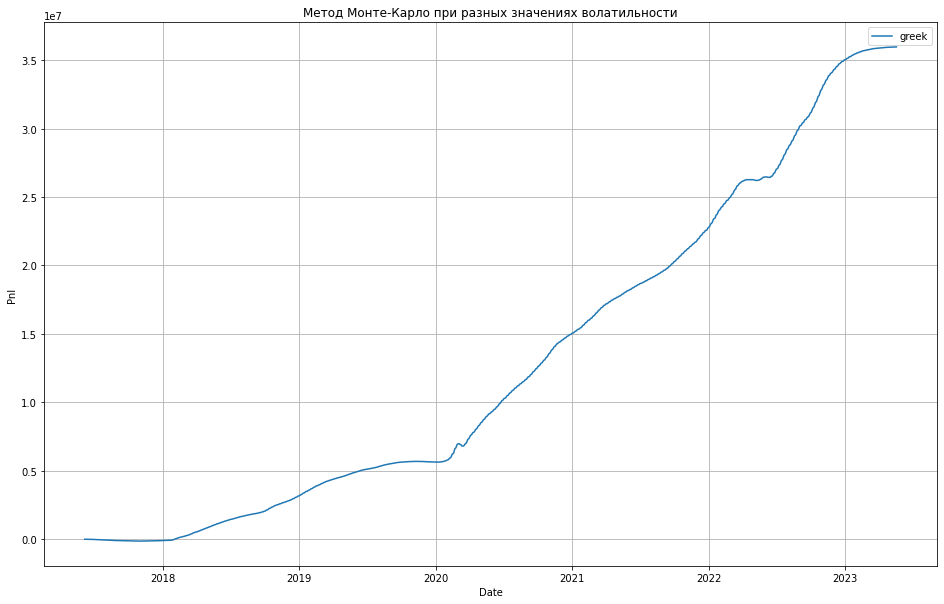

In [102]:
ask = options_prices.Ask.values
bid = options_prices.Bid.values

delta = options_prices.Delta.values
signals_monte_greek = ((((opt_prices_monte_carlo_25>options_prices.Ask))*1-1* (opt_prices_monte_carlo_25<options_prices.Bid)))*(np.array(delta>x.x[0]) + np.array(delta<x.x[1]))
pnl_bs_greek, trade_value_bs_greeek = run_backtest(signals_monte_greek.values, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_bs_greek, label= "greek")
plt.title("Метод Монте-Карло при разных значениях волатильности")
plt.legend()
plt.ylabel("Pnl")
plt.xlabel("Date")
plt.grid()
plt.show()

In [98]:
def calc_signals(x,opt_prices,delta, ask, bid, opt_exp, opt_date, opt_date_closest_index,exp_closest_index):
    delta_thr_up = x[0]
    delta_thr_down = x[1]
    signals_monte_10 = ((((opt_prices>ask))*1-1* (opt_prices<bid)))*(np.array(delta>delta_thr_up) + np.array(delta<delta_thr_down))
    pnl_bs_10, trade_value_bs_10 = run_backtest(signals_monte_10, ask, bid, opt_exp, opt_date, opt_date_closest_index,exp_closest_index)
    return - calc_sharpe(pnl_bs_10)

In [29]:
signals_monte_10 = ((opt_prices_monte_carlo_10>options_prices.Ask)*1-1* (opt_prices_monte_carlo_10<options_prices.Bid)).values
signals_monte_25 = ((opt_prices_monte_carlo_25>options_prices.Ask)*1-1* (opt_prices_monte_carlo_25<options_prices.Bid)).values
signals_monte_vix = ((opt_prices_monte_carlo_vix>options_prices.Ask)*1-1* (opt_prices_monte_carlo_vix<options_prices.Bid)).values
signals_monte_std = ((opt_prices_monte_carlo_std>options_prices.Ask)*1-1* (opt_prices_monte_carlo_std<options_prices.Bid)).values

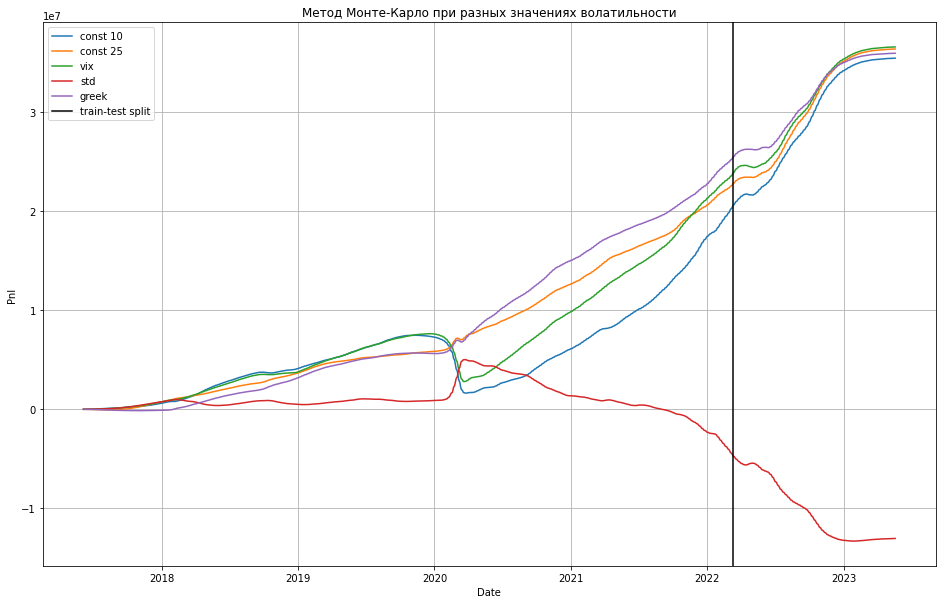

In [104]:
pnl_bs_10, trade_value_bs_10 = run_backtest(signals_monte_10, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
pnl_bs_25, trade_value_bs_25 = run_backtest(signals_monte_25, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
pnl_bs_vix, trade_value_bs_vix = run_backtest(signals_monte_vix, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
pnl_bs_std, trade_value_bs_std = run_backtest(signals_monte_std, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))

plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_bs_10, label= "const 10")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_bs_25, label= "const 25")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_bs_vix, label= "vix")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_bs_std, label= "std")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_bs_greek, label= "greek")
plt.axvline(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]][1200], unit="s"), label= "train-test split", color = "black")
plt.title("Метод Монте-Карло при разных значениях волатильности")
plt.legend()
plt.ylabel("Pnl")
plt.xlabel("Date")
plt.grid()
plt.show()

In [53]:
print(int(pnl_bs_10[1200]))
print(int(pnl_bs_25[1200]))
print(int(pnl_bs_vix[1200]))
print(int(pnl_bs_std[1200]))

20547323
22755754
23805521
-4665155


In [ ]:
pnl_bs, trade_value_bs = run_backtest(signals_b_s, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)

plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]], unit="s"),pnl_bs)
# plt.ylim(0, 10000)
plt.grid()
plt.show()

In [55]:
print(calc_sharpe(pnl_bs_10[:1200]))
print(calc_sharpe(pnl_bs_25[:1200]))
print(calc_sharpe(pnl_bs_vix[:1200]))
print(calc_sharpe(pnl_bs_std[:1200])
     print(calc_sharpe(pnl_bs_std[:1200]))

15.89364540573951
43.885909210060596
20.80483473129184
-4.691766241350702


In [56]:
print(calc_sharpe(pnl_bs_10[1200:] - int(pnl_bs_10[1200])) )
print(calc_sharpe(pnl_bs_25[1200:] - int(pnl_bs_25[1200])))
print(calc_sharpe(pnl_bs_vix[1200:] - int(pnl_bs_vix[1200])))
print(calc_sharpe(pnl_bs_std[1200:] - int(pnl_bs_std[1200])))

23.876471769847505
22.222499654844594
21.56307359489667
-16.379639078721183


In [57]:
print((pnl_bs_10[-1] - pnl_bs_10[1200]))
print((pnl_bs_25[-1] - pnl_bs_25[1200]))
print((pnl_bs_vix[-1] - pnl_bs_vix[1200]))
print((pnl_bs_std[-1] - pnl_bs_std[1200]))

14917081.540001392
13636486.916002996
12799672.908504844
-8381227.1203957135


In [ ]:
pnl_binomial, trade_value_binomial = run_backtest(signals_binomial, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_binomial)
# plt.ylim(0, 10000)
plt.grid()
plt.show()

In [ ]:
pnl_binomial, trade_value_binomial = run_backtest(signals_binomial, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_binomial)
# plt.ylim(0, 10000)
plt.grid()
plt.show()

In [ ]:
pnl_binomial, trade_value_binomial = run_backtest(signals_binomial, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]-1], unit="s"),pnl_binomial)
# plt.ylim(0, 10000)
plt.grid()
plt.show()

In [48]:
(signals_monte_25<0).sum()

3826885

In [49]:
(signals_monte_25>0).sum()

2480628

In [50]:
(signals_monte_vix<0).sum()

4372182

In [105]:
options_prices

,Date,UnderlyingExp,OptExp,Forward,Type,Style,Strike,Bid,Ask,IVRaw,IVInt,Delta,Gamma,Vega,Theta,Unnamed: 16
0,1496707200,1497571200,1496793600,2430.75,P,E,100.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
1,1496707200,1497571200,1496793600,2430.75,P,E,500.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
2,1496707200,1497571200,1496793600,2430.75,P,E,800.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
3,1496707200,1497571200,1496793600,2430.75,P,E,825.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
4,1496707200,1497571200,1496793600,2430.75,P,E,850.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188751,1666915200,1686873600,1684454400,3978.00,C,E,5400.0,2.80,3.45,0.185762,0.185762,0.016306,0.000076,1.177011,-0.053464,NaN
8188752,1666915200,1686873600,1684454400,3978.00,C,E,5500.0,1.95,2.50,0.186218,0.186218,0.011806,0.000057,0.890953,-0.040615,NaN
8188753,1666915200,1686873600,1684454400,3978.00,C,E,5600.0,1.40,1.80,0.187206,0.187206,0.008662,0.000043,0.679999,-0.031188,NaN
8188754,1666915200,1686873600,1684454400,3978.00,C,E,5700.0,0.95,1.35,0.187814,0.187814,0.006245,0.000032,0.509701,-0.023430,NaN


In [106]:
opt_prices_monte_carlo_25

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
exp_opt_value

array([0., 0., 0., ..., 0., 0., 0.])

In [114]:
true_signals = 1*(options_prices.Ask<exp_opt_value) + 0*(options_prices.Ask>exp_opt_value)
true_signals

0          0
1          0
2          0
3          0
4          0
          ..
8188751    0
8188752    0
8188753    0
8188754    0
8188755    0
Name: Ask, Length: 7792131, dtype: int64

In [111]:
from sklearn.datasets import make_classification
y = true_signals
X = 

array([[-1.66853167, -1.29901346,  0.2746472 , -0.60362044],
       [-2.9728827 , -1.08878294,  0.70885958,  0.42281857],
       [-0.59614125, -1.37007001, -3.11685659,  0.64445203],
       ...,
       [ 0.91711204,  1.10596645,  0.86766522, -2.25625012],
       [ 0.10027664,  1.45875846, -0.44360274, -0.67002328],
       [ 1.0415229 , -0.01987143,  0.15216419, -1.9405334 ]])

In [113]:
clf.fit(X, y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [115]:
X

array([[-1.66853167, -1.29901346,  0.2746472 , -0.60362044],
       [-2.9728827 , -1.08878294,  0.70885958,  0.42281857],
       [-0.59614125, -1.37007001, -3.11685659,  0.64445203],
       ...,
       [ 0.91711204,  1.10596645,  0.86766522, -2.25625012],
       [ 0.10027664,  1.45875846, -0.44360274, -0.67002328],
       [ 1.0415229 , -0.01987143,  0.15216419, -1.9405334 ]])

In [ ]:
options_prices.values[]